In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Dense, LeakyReLU, Reshape, Flatten, BatchNormalization,
                                     Dropout, Input)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import os

In [2]:
# ------------------
# Hyperparameters
# ------------------
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
n_critic = 5  # Number of discriminator updates per generator update

In [3]:
# ------------------
# Load and preprocess MNIST
# ------------------
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

In [4]:
# ------------------
# Build the Generator
# ------------------
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

# ------------------
# Build the Discriminator
# ------------------
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [5]:
# ------------------
# Optimizers
# ------------------
opt_d = Adam(4e-4, beta_1=0.5)
opt_g = Adam(2e-4, beta_1=0.5)

# ------------------
# Build and compile Discriminator
# ------------------
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=opt_d, metrics=['accuracy'])

# ------------------
# Build Generator
# ------------------
generator = build_generator()

# ------------------
# Combined GAN
# ------------------
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=opt_g)

# — Done! —
print(discriminator.summary())
print(generator.summary())
print(combined.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [11]:
# ------------------
# Sampling and Plotting
# ------------------
def sample_images(epoch, generator, latent_dim, output_dir="images"):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c, figsize=(5, 5))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    fig.savefig(f"{output_dir}/mnist_{epoch}.png")
    plt.close()

# ------------------
# Training Loop
# ------------------
d_losses = []
g_losses = []
d_accuracies = []

def train(epochs, batch_size=128, sample_interval=50):
    half_batch = batch_size // 2

    for epoch in range(1, epochs + 1):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[idx]
        real_imgs += np.random.normal(0, 0.05, real_imgs.shape)

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        gen_imgs = generator.predict(noise)

        real_y = np.random.uniform(0.9, 1.0, (half_batch, 1))
        fake_y = np.random.uniform(0.0, 0.1, (half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))
        g_loss = combined.train_on_batch(noise, valid_y)

        d_losses.append(d_loss[0])
        d_accuracies.append(d_loss[1])
        g_losses.append(g_loss)

        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        if epoch % sample_interval == 0:
            sample_images(epoch, generator, latent_dim)

In [14]:
# ------------------
# Start training
# ------------------
train(epochs=1000, batch_size=100, sample_interval=25)


2/2 [==============================] - 0s 4ms/step
1 [D loss: 0.9024, acc.: 0.00%] [G loss: 0.9930]
2/2 [==============================] - 0s 4ms/step
2 [D loss: 0.5422, acc.: 0.00%] [G loss: 1.8697]
2/2 [==============================] - 0s 4ms/step
3 [D loss: 0.7431, acc.: 0.00%] [G loss: 1.3875]
2/2 [==============================] - 0s 5ms/step
4 [D loss: 0.5745, acc.: 0.00%] [G loss: 1.6669]
2/2 [==============================] - 0s 6ms/step
5 [D loss: 0.8148, acc.: 0.00%] [G loss: 1.1421]
2/2 [==============================] - 0s 5ms/step
6 [D loss: 0.5257, acc.: 0.00%] [G loss: 1.9356]
2/2 [==============================] - 0s 5ms/step
7 [D loss: 0.9769, acc.: 0.00%] [G loss: 0.8816]
2/2 [==============================] - 0s 6ms/step
8 [D loss: 0.5443, acc.: 0.00%] [G loss: 1.5387]
2/2 [==============================] - 0s 7ms/step
9 [D loss: 0.8537, acc.: 0.00%] [G loss: 1.0635]
2/2 [==============================] - 0s 6ms/step
10 [D loss: 0.6125, acc.: 0.00%] [G loss: 1.4184]

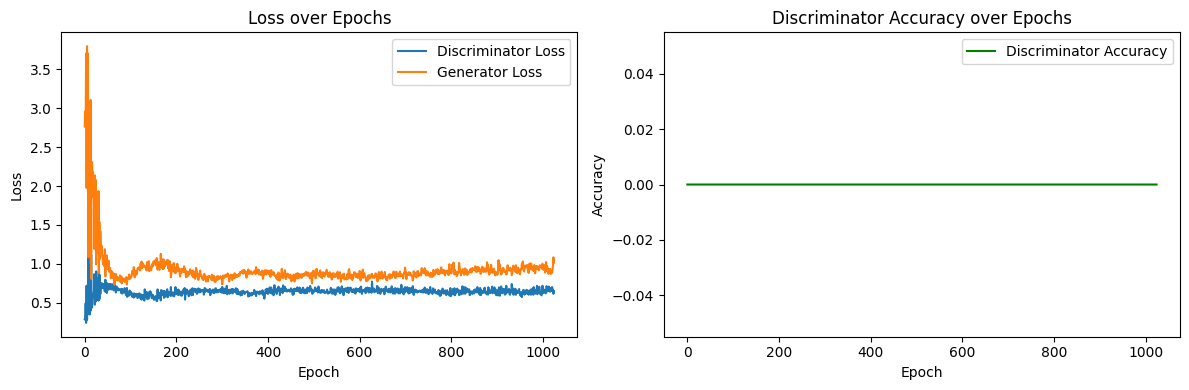

In [15]:
def plot_training_progress():
    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(d_accuracies, label='Discriminator Accuracy', color='green')
    plt.title("Discriminator Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_progress()

In [16]:
# Save the generator model
generator.save("generator_model_v2.h5")

# Save the discriminator model
discriminator.save("discriminator_model_v2.h5")